In [1]:
%%capture
%pip install optuna
!git clone https://github.com/rossetl/NNDL.git
%cd NNDL/Homework\ 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
BATCHSIZE = 128
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', DEVICE)

Training device: cuda


In [70]:
%%capture
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])
test_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transform)
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

$D(x)$ is the discriminator network which outputs the (scalar) probability that $x$ came from training data rather than the generator. Hence, $D(x)$ should be HIGH when $x$ comes from training data and LOW when $x$ comes from the generator.

Let $z$ be a latent space vector sampled from a standard normal distribution. $G(z)$ represents the generator function which maps the latent vector $z$ to data-space. The goal of $G$ is to estimate the distribution that the training data comes from ($p_{data}$) so it can generate fake samples from that estimated distribution ($p_{g}$).

+ $D$ tries to maximize the probability it correctly classifies reals and fakes ($\log D(x)$)
+ $G$ tries to minimize the probability that $D$ will predict its outputs are fake ($\log (1-D(G(z)$).

The GAN loss function is therefore:
$$\min_G \max_D V(D,G) = \mathbb{E_{x \sim p_{data}(x)}}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z)))]$$

All model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02

In [71]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [104]:
image_size = 28
nc = 1
nz = 100
ndf = 64
ngf = 64

In [105]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

## Discriminator

In [106]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## Initialization

In [120]:
netG = Generator().to(DEVICE)
netG.apply(weights_init)
print(netG)

netD = Discriminator().to(DEVICE)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4)

We will use the Binary Cross Entropy loss (BCELoss) function which is defined in PyTorch. We define our real label as 1 and the fake label as 0. Finally, we set up two separate optimizers, one for $D$ and one for $G$. For keeping track of the generator’s learning progression, we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution.

In [121]:
loss_fn = nn.BCELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=DEVICE)

real_label = 1.
fake_label = 0.

beta1 = 0.5
lr = 2e-4

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [122]:
num_epochs = 10

img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader, 0):

        ######################
        ## Update D network ##
        ######################

        # Train with all-real batch
        netD.zero_grad()
        real_img = data[0].to(DEVICE)
        batch_size = real_img.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
        # Forward pass real batch through D
        output = netD(real_img).view(-1)
        errD_real = loss_fn(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        noise = torch.randn(batch_size, nz, 1, 1, device=DEVICE)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = loss_fn(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ######################
        ## Update G network ##
        ######################

        netG.zero_grad()
        label.fill_(real_label) # Fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = loss_fn(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[1/10][0/469]	Loss_D: 1.6511	Loss_G: 1.3699	D(x): 0.4340	D(G(z)): 0.4870 / 0.2923
[1/10][100/469]	Loss_D: 0.4981	Loss_G: 3.2513	D(x): 0.8706	D(G(z)): 0.2720 / 0.0548
[1/10][200/469]	Loss_D: 0.1990	Loss_G: 3.2620	D(x): 0.9367	D(G(z)): 0.1179 / 0.0497
[1/10][300/469]	Loss_D: 0.1726	Loss_G: 3.8946	D(x): 0.9351	D(G(z)): 0.0928 / 0.0292
[1/10][400/469]	Loss_D: 0.3063	Loss_G: 3.2321	D(x): 0.8668	D(G(z)): 0.1318 / 0.0523
[2/10][0/469]	Loss_D: 0.3228	Loss_G: 2.3694	D(x): 0.8276	D(G(z)): 0.0780 / 0.1305
[2/10][100/469]	Loss_D: 0.2890	Loss_G: 2.7404	D(x): 0.8035	D(G(z)): 0.0395 / 0.1002
[2/10][200/469]	Loss_D: 0.6532	Loss_G: 3.9355	D(x): 0.9491	D(G(z)): 0.3929 / 0.0412
[2/10][300/469]	Loss_D: 0.4266	Loss_G: 2.7783	D(x): 0.8525	D(G(z)): 0.2133 / 0.0805
[2/10][400/469]	Loss_D: 0.6361	Loss_G: 1.5408	D(x): 0.6106	D(G(z)): 0.0675 / 0.2681
[3/10][0/469]	Loss_D: 0.4884	Loss_G: 1.6841	D(x): 0.7074	D(G(z)): 0.0916 / 0.2215
[3/10][100/469]	Loss_D: 0.6284	Loss_G: 3.1666	D(x): 0.8660	D(G(z)): 0.3486 / 0.057

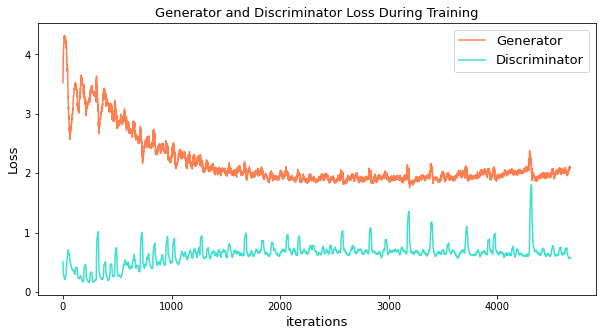

In [123]:
N = 20
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training", size=13)
plt.plot(np.convolve(G_losses, np.ones(N)/N, mode='valid'), c='coral',label="Generator")
plt.plot(np.convolve(D_losses, np.ones(N)/N, mode='valid'), c='turquoise', label="Discriminator")
plt.xlabel("iterations", size=13)
plt.ylabel("Loss", size=13)
plt.legend(fontsize=13)
plt.show()

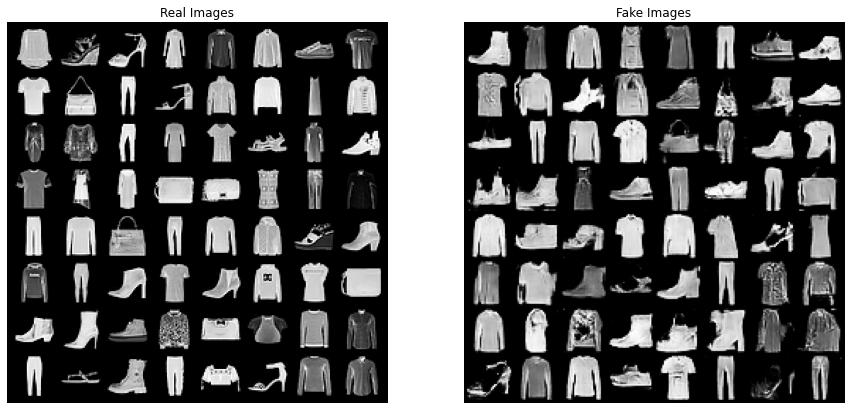

In [124]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [125]:
torch.save(netG.state_dict(), 'generator_params.pth')
torch.save(netD.state_dict(), 'discriminator_params.pth')